### Data loading

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

In [1]:
import os
from PIL import Image
import numpy as np
import random
import itertools

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
from torchvision.utils import save_image
import torch.nn.functional as F

import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

### Часть 1. Перенос стиля при помощи pix2pix

В этом задании требуется реализовывать перенос стиля на спаренных данных (paired data) для датасета, состоящего из масок и фото фасадов домов.
Подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля.

based on Pix2Pix explained with code

#### 1.1 Dataloader

In [3]:
class FacadesDataset(Dataset):
    def __init__(self, fpath, target_size=None):
        self.filenames = [os.path.join(fpath, f) for f in os.listdir(fpath) if f.endswith(".jpg")]
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        img = image[:, :, : image_width // 2]
        mask = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(mask, size=target_size)
            real = nn.functional.interpolate(img, size=target_size)

        return real, condition

#### 1.2 Network

In [4]:
class ConvDownsample(nn.Module):
    """
    Layer size decrease
    """
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):

        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [5]:
class ConvUpsample(nn.Module):
    """
    Layer size increase
    """
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True, dropout=False):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [6]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.encoders = [
            ConvDownsample(in_channels, 64, batchnorm=False),  # batch_size x 64 x 128 x 128
            ConvDownsample(64, 128),  # batch_size x 128 x 64 x 64
            ConvDownsample(128, 256),  # batch_size x 256 x 32 x 32
            ConvDownsample(256, 512),  # batch_size x 512 x 16 x 16
            ConvDownsample(512, 512),  # batch_size x 512 x 8 x 8
            ConvDownsample(512, 512),  # batch_size x 512 x 4 x 4
            ConvDownsample(512, 512),  # batch_size x 512 x 2 x 2
            ConvDownsample(512, 512, batchnorm=False),  # batch_size x 512 x 1 x 1
        ]
      
        self.decoders = [
            ConvUpsample(512, 512, dropout=True),  # batch_size x 512 x 2 x 2
            ConvUpsample(1024, 512, dropout=True),  # batch_size x 512 x 4 x 4
            ConvUpsample(1024, 512, dropout=True),  # batch_size x 512 x 8 x 8
            ConvUpsample(1024, 512),  # batch_size x 512 x 16 x 16
            ConvUpsample(1024, 256),  # batch_size x 256 x 32 x 32
            ConvUpsample(512, 128),  # batch_size x 128 x 64 x 64
            ConvUpsample(256, 64),  # batch_size x 64 x 128 x 128
        ]

        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]

        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        x = self.final_conv(x)
        return self.tanh(x)

In [7]:
class Discriminator(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = ConvDownsample(input_channels, 64, batchnorm=False)
        self.d2 = ConvDownsample(64, 128)
        self.d3 = ConvDownsample(128, 256)
        self.d4 = ConvDownsample(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [8]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, 0)

In [9]:
class Pix2Pix(nn.Module):

    def __init__(self, in_channels, out_channels, learning_rate=1e-3, lambda_recon=200):

        super().__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.generator = Generator(in_channels, out_channels)
        self.discriminator = Discriminator(in_channels + out_channels)

        # intializing weights
        self.generator = self.generator.apply(weights_init)
        self.discriminator = self.discriminator.apply(weights_init)

        self.generator = self.generator.to(self.device)
        self.discriminator = self.discriminator.to(self.device)


        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.reconstruction_criterion = nn.L1Loss()

        self.lambda_ = lambda_recon

        self.gen_optim = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.disc_optim = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)


    def _gen_step(self, real_images, conditioned_images):
        fake_images = self.generator(conditioned_images)
        disc_logits = self.discriminator(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))
        reconstruction_loss = self.reconstruction_criterion(fake_images, real_images)

        return adversarial_loss + self.lambda_ * reconstruction_loss, fake_images

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.generator(conditioned_images).detach()
        fake_logits = self.discriminator(fake_images, conditioned_images)

        real_logits = self.discriminator(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def train_epoch(self, batch, batch_idx=0, optimizer_idx=0):
        real, condition = batch
        real, condition =  real.to(self.device), condition.to(self.device)
      
        disc_loss = self._disc_step(real, condition)
        self.disc_optim.zero_grad()
        disc_loss.backward()
        self.disc_optim.step()
        
        gen_loss, imgs = self._gen_step(real, condition)
        self.gen_optim.zero_grad()
        gen_loss.backward()
        self.gen_optim.step()
      
        return disc_loss.cpu().detach().numpy(), gen_loss.cpu().detach().numpy(), imgs

    def unload(self):
        self.generator = self.generator.to("cpu")
        self.discriminator = self.discriminator.to("cpu")

#### 1.3 Training

In [10]:
num_epochs = 500
batch_size = 32
lr = 1e-3
target_size = 256

In [11]:
dataset = FacadesDataset(fpath = r"/content/facades/train", target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
pix2pix = Pix2Pix(3, 3, learning_rate=lr)

In [13]:
t_epochs = trange(num_epochs, desc='Epoch', leave=True)

_disc_loss, _gen_loss = [], []
for epoch in t_epochs:
    for batch in dataloader:
        loss_disc, loss_gen, imgs = pix2pix.train_epoch(batch)
        _disc_loss.append(loss_disc)
        _gen_loss.append(loss_gen)
        t_epochs.set_description("Epoch {}: Loss discriminator {:.5f}; Loss generator {:.5f}".format(epoch, loss_disc, loss_gen ))
        if epoch % 10 == 0:
          save_image(imgs[0].cpu(), f"epoch_{epoch}.png")

_disc_loss = np.array(_disc_loss)
_gen_loss = np.array(_gen_loss)

Epoch 499: Loss discriminator 0.01674; Loss generator 27.68256: 100%|██████████| 500/500 [1:15:00<00:00,  9.00s/it]


In [21]:
# torch.save(pix2pix.generator, "generator.pkl")
# torch.save(pix2pix.discriminator, "discriminator.pkl")

In [20]:
# np.savetxt('gen_loss.txt', _gen_loss, delimiter=',')
# np.savetxt('disc_loss.txt', _disc_loss, delimiter=',')

Text(0.5, 1.0, 'Discriminator loss')

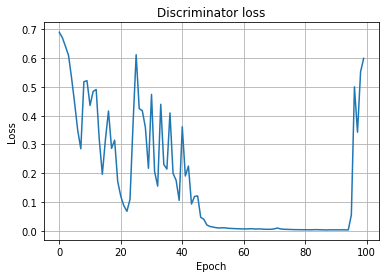

In [ ]:
plt.figure()
plt.plot(np.mean(_disc_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss")

Text(0.5, 1.0, 'Generator loss')

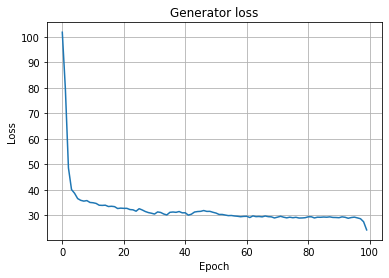

In [ ]:
plt.figure()
plt.plot(np.mean(_gen_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss")

#### 1.4 Generated image samples

In [ ]:
for batch in dataloader:
      real, condition = batch
      real, condition =  real.to(pix2pix.device), condition.to(pix2pix.device)
      _, imgs = pix2pix._gen_step(real, condition)
      break

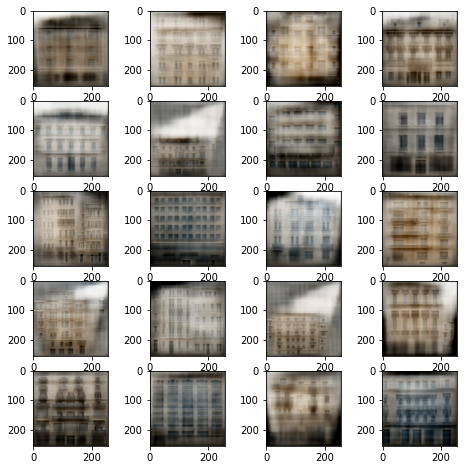

In [ ]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.transpose(imgs[i].cpu().detach().numpy(), [1, 2, 0])
    plt.imshow(np.clip(img, 0, 1))
plt.show()

#### 1.5 Большее количество эпох (500 vs 100)

Text(0.5, 1.0, 'Discriminator loss')

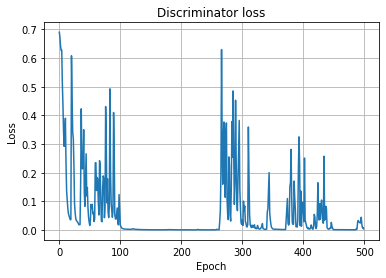

In [14]:
plt.figure()
plt.plot(np.mean(_disc_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss")

Text(0.5, 1.0, 'Generator loss')

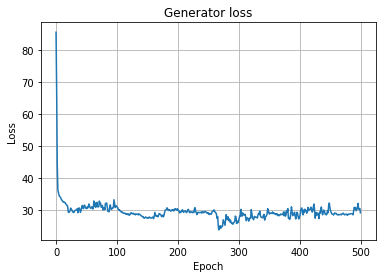

In [15]:
plt.figure()
plt.plot(np.mean(_gen_loss.reshape(-1, len(dataloader)), axis=1))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss")

In [18]:
for batch in dataloader:
      real, condition = batch
      real, condition =  real.to(pix2pix.device), condition.to(pix2pix.device)
      _, imgs = pix2pix._gen_step(real, condition)
      break

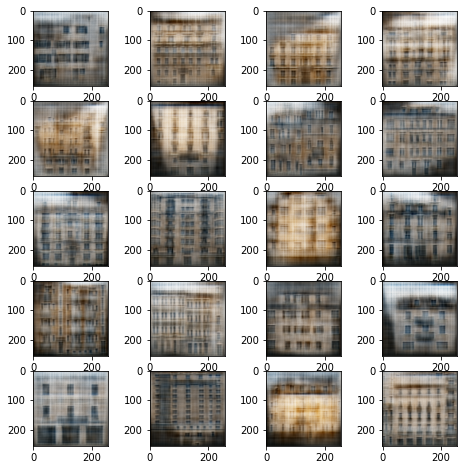

In [19]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, i)
    img = np.transpose(imgs[i].cpu().detach().numpy(), [1, 2, 0])
    plt.imshow(np.clip(img, 0, 1))
plt.show()

In [40]:
pix2pix.unload()

### Часть 2. Перенос стиля при помощи cycleGAN

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017).

#### 2.1 Dataloader

In [2]:
class FacadesDataset(Dataset):
    def __init__(self, fpath, target_size=None):
        self.filenames = [os.path.join(fpath, f) for f in os.listdir(fpath) if f.endswith(".jpg")]
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        img_A = image[:, :, image_width // 2 :]

        image = Image.open(self.filenames[random.randint(0, len(self.filenames) - 1)])
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]
        img_B = image[:, :, : image_width // 2]

        target_size = self.target_size
        if target_size:
            img_A = nn.functional.interpolate(img_A, size=target_size)
            img_B = nn.functional.interpolate(img_B, size=target_size)

        return img_A, img_B

#### 2.2 Network

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, 0)

In [7]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [14]:
class CycleGAN(nn.Module):

    def __init__(self, learning_rate=1e-3):

        super().__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.generator_A2B = Generator().to(self.device)
        self.generator_B2A = Generator().to(self.device)

        self.discriminator_A = Discriminator().to(self.device)
        self.discriminator_B = Discriminator().to(self.device)       

        # intializing weights
        self.generator_A2B.apply(weights_init)
        self.generator_B2A.apply(weights_init)
        self.discriminator_A.apply(weights_init)
        self.discriminator_B.apply(weights_init)

        # Losses
        self.cycle_loss = torch.nn.L1Loss().to(self.device)
        self.identity_loss = torch.nn.L1Loss()#.to(self.device)
        self.adversarial_loss = torch.nn.MSELoss()#.to(self.device)


        # Optimizers
        self.gen_optim = torch.optim.Adam(itertools.chain(self.generator_A2B.parameters(), self.generator_B2A.parameters()), lr=learning_rate, betas=(0.5, 0.999))
        self.discA_optim = torch.optim.Adam(self.discriminator_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
        self.discB_optim = torch.optim.Adam(self.discriminator_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))


        # Buffer
        self.buffer_A = ReplayBuffer()
        self.buffer_B = ReplayBuffer()

    def _gen_step(self, real_image_A, real_image_B, real_label):



        self.gen_optim.zero_grad()

        # Identity loss
        # self.generator_A2B.to(self.device)        
        identity_image_A = self.generator_B2A(real_image_A)
        loss_identity_A = self.identity_loss(identity_image_A, real_image_A) * 5.0
        del identity_image_A
        # self.generator_A2B.to("cpu")
        torch.cuda.empty_cache()

        # self.generator_B2A.to(self.device)
        identity_image_B = self.generator_A2B(real_image_B)
        loss_identity_B = self.identity_loss(identity_image_B, real_image_B) * 5.0
        del identity_image_B
        # self.generator_B2A.to("cpu")       
        torch.cuda.empty_cache()


        # GAN loss
        fake_image_A = self.generator_B2A(real_image_B)
        fake_output_A = self.discriminator_A(fake_image_A)
        loss_GAN_B2A = self.adversarial_loss(fake_output_A, real_label)

        fake_image_B = self.generator_A2B(real_image_A)
        fake_output_B = self.discriminator_B(fake_image_B)
        loss_GAN_A2B = self.adversarial_loss(fake_output_B, real_label)
      
        # Cycle loss
        recovered_image_A = self.generator_B2A(fake_image_B)
        loss_cycle_ABA = self.cycle_loss(recovered_image_A, real_image_A) * 10.0

        recovered_image_B = self.generator_A2B(fake_image_A)
        loss_cycle_BAB = self.cycle_loss(recovered_image_B, real_image_B) * 10.0

        # Total loss
        gen_loss = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        gen_loss.backward()
        self.gen_optim.step()

        # self.generator_A2B.to('cpu')
        # self.generator_B2A.to('cpu')

        return gen_loss, fake_image_A, fake_image_B

    def _disc_step(self, real_image, real_label, fake_label, optimizer, discriminator, fake_image, fake_buffer):
        
        optimizer.zero_grad()

        # Real A image loss
        real_output = discriminator(real_image)
        disc_loss_real = self.adversarial_loss(real_output, real_label)

        # Fake A image loss
        fake_image = fake_buffer.push_and_pop(fake_image)
        fake_output = self.discriminator_A(fake_image.detach())
        disc_loss_fake = self.adversarial_loss(fake_output, fake_label)

        # Total loss
        disc_loss = (disc_loss_real + disc_loss_fake) / 2

        disc_loss.backward()
        optimizer.step()

        return disc_loss

    def train_epoch(self, batch):
        real_image_A, real_image_B = batch
        real_image_A, real_image_B =  real_image_A.to(self.device), real_image_B.to(self.device)
        real_label = torch.full((batch_size, 1), 1, device=self.device, dtype=torch.float32)
        fake_label = torch.full((batch_size, 1), 0, device=self.device, dtype=torch.float32)        

        gen_loss, fake_image_A, fake_image_B = self._gen_step(real_image_A, real_image_B, real_label)


      
        disc_loss_A = self._disc_step(real_image=real_image_A, real_label=real_label, 
                        fake_label=fake_label, optimizer=self.discA_optim, 
                        discriminator=self.discriminator_A, fake_image=fake_image_A, 
                        fake_buffer=self.buffer_A)
        
        disc_loss_B = self._disc_step(real_image=real_image_B, real_label=real_label, 
                fake_label=fake_label, optimizer=self.discB_optim, 
                discriminator=self.discriminator_B, fake_image=fake_image_B, 
                fake_buffer=self.buffer_B)
        
        disc_loss = disc_loss_A + disc_loss_B
        torch.cuda.empty_cache()
        return gen_loss.cpu().detach().numpy(), disc_loss.cpu().detach().numpy(), fake_image_A, fake_image_B

    def unload(self):
        self.generator_A2B.to("cpu")
        self.generator_B2A.to("cpu")
        self.discriminator_A.to("cpu")
        self.discriminator_B.to("cpu")
        self.cycle_loss.to("cpu")
        self.identity_loss.to("cpu")
        self.adversarial_loss.to("cpu")
        return

#### 2.3 Training

In [24]:
num_epochs = 500
batch_size = 16
lr = 1e-3
target_size = 256

In [26]:
dataset = FacadesDataset(fpath = r"/content/facades/train", target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
cycle_gan = CycleGAN(learning_rate=lr)

In [28]:
t_epochs = trange(num_epochs, desc='Epoch', leave=True)

_disc_loss, _gen_loss = [], []
for epoch in t_epochs:
    for batch in dataloader:
        loss_gen, loss_disc, imgs_A, imgs_B = cycle_gan.train_epoch(batch)
        _disc_loss.append(loss_disc)
        _gen_loss.append(loss_gen)
        t_epochs.set_description("Epoch {}: Loss discriminator {:.5f}; Loss generator {:.5f}".format(epoch, loss_disc, loss_gen ))
        if epoch % 10 == 0:
          save_image(imgs_A[0].cpu(), "epoch_{epoch:02d}A.png".format(epoch))
          save_image(imgs_B[0].cpu(), "epoch_{epoch:02d}B.png".format(epoch))

_disc_loss = np.array(_disc_loss)
_gen_loss = np.array(_gen_loss)

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: ignored

In [29]:
cycle_gan.unload()
del cycle_gan
torch.cuda.empty_cache()

In [ ]:
torch.save(pix2pix.generator, "generator.pkl")
torch.save(pix2pix.discriminator, "discriminator.pkl")